In [1]:
import torch_tensorrt
import multiprocessing as mp
import os
import numpy as np
import configparser

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import tqdm

from torchvision import models
from glob import glob

from PIL import Image
from tqdm import tqdm
from torch_tensorrt import compile as tx_compile

print(torch_tensorrt.__version__)

1.4.0


In [2]:
config = configparser.ConfigParser()
config.read('./config/config.ini')
model_name = "model_ch3_bottom2"

transform = transforms.Compose([
    transforms.Resize(eval(dict(config[model_name])["transforms"])["resize"]),
    transforms.ToTensor(),
    transforms.Normalize(mean=eval(dict(config[model_name])["transforms"])["normalize"][0],
                         std=eval(dict(config[model_name])["transforms"])["normalize"][1]),
])
idx_to_cls = eval(dict(config[model_name])["idx_to_cls"])
num_classes = int(dict(config[model_name])["num_classes"])

model = models.efficientnet_v2_l(weights=None)

model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
check_point = torch.load("./model_ch3_bottom2.pth")

for key in list(check_point.keys()):
    if "module." in key:
        check_point[key.replace("module.", "")] = check_point[key]
        del check_point[key]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.load_state_dict(check_point)
model.to(device)
model.eval()

img_list = glob("./img/*.jpg")
torch_list = []

starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
torch_timings=np.zeros((len(img_list), 1))

with torch.no_grad():
    for i, image_path in enumerate(tqdm(img_list, ncols=160, ascii=" =", unit="image")):
        starter.record()
        image = Image.open(image_path)
        image = transform(image).unsqueeze(0).to(device)
        outputs = model(image)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        max_prob, predicted = torch.max(probabilities, 1)

        torch_list.append(predicted.item())
        ender.record()
        # WAIT FOR GPU SYNC
        torch.cuda.synchronize()
        curr_time = starter.elapsed_time(ender)
        torch_timings[i] = curr_time

100%|==================================================================================================================| 16673/16673 [11:20<00:00, 24.50image/s]


In [3]:
compile_settings = {
    "inputs": [torch_tensorrt.Input(
        shape=[1, 3, 480, 480],
        # min_shape=[1, 3, 480, 480],
        # opt_shape=[16, 3, 480, 480],
        # max_shape=[32, 3, 480, 480],
        # For static size shape=[1, 3, 224, 224]
        dtype=torch.half, # Datatype of input tensor. Allowed options torch.(float|half|int8|int32|bool)
    )],
    "enabled_precisions": {torch.half}, # Run with FP16
}

trt_ts_module = tx_compile(model, **compile_settings)

tensorrt_list = []

starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
tensorrt_timings=np.zeros((len(img_list), 1))

print("run")

with torch.no_grad():
    for i, image_path in enumerate(tqdm(img_list, ncols=160, ascii=" =", unit="image")):
        starter.record()
        image = Image.open(image_path)
        image = transform(image).unsqueeze(0).to(device).half()
        outputs = trt_ts_module(image)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        max_prob, predicted = torch.max(probabilities, 1)

        tensorrt_list.append(predicted.item())
        ender.record()
        # WAIT FOR GPU SYNC
        torch.cuda.synchronize()
        curr_time = starter.elapsed_time(ender)
        tensorrt_timings[i] = curr_time

The compiler is going to use the user setting Half
This conflict may cause an error at runtime due to partial compilation being enabled and therefore
compatibility with PyTorch's data type convention is required.
If you do indeed see errors at runtime either:
- Remove the dtype spec for x.1
- Disable partial compilation by setting require_full_compilation to True


run


100%|==================================================================================================================| 16673/16673 [05:22<00:00, 51.69image/s]


In [4]:
# 두 출력 간의 유사성 확인
if torch.allclose(torch.tensor(torch_list), torch.tensor(tensorrt_list), atol=1e-3):
    print("PyTorch와 TensorRT 모델의 출력이 유사합니다.")
else:
    print("PyTorch와 TensorRT 모델의 출력이 다릅니다.")

PyTorch와 TensorRT 모델의 출력이 다릅니다.


In [5]:
x = torch.tensor(torch_list)

In [6]:
x

tensor([0, 0, 1,  ..., 1, 1, 0])

In [7]:
(torch.tensor(torch_list) != torch.tensor(tensorrt_list)).sum()

tensor(1)

In [8]:
np.round(np.mean(torch_timings), 3)

40.637

In [9]:
np.round(np.mean(tensorrt_timings), 3)

19.223

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

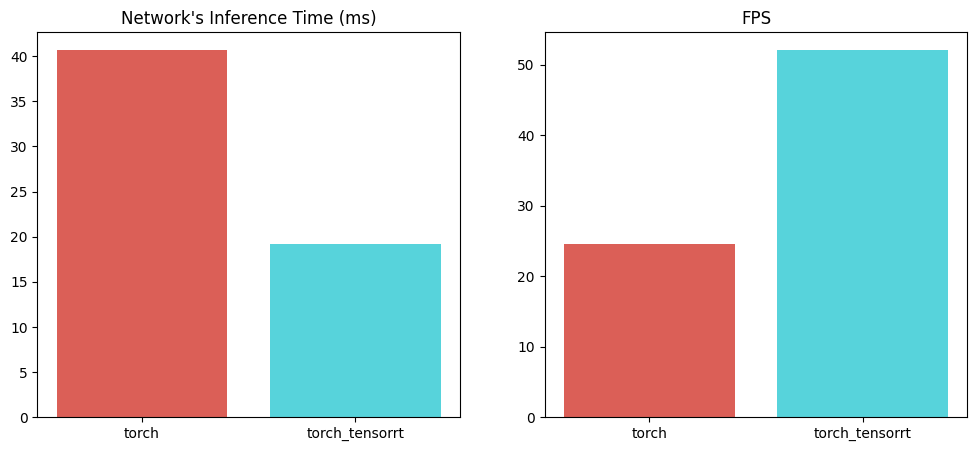

In [11]:
x = np.arange(3)
years = ['torch', 'torch_tensorrt']
values = [np.round(np.mean(torch_timings), 3), np.round(np.mean(tensorrt_timings), 3)]
values2 = [(1000 / np.round(np.mean(torch_timings), 3)), (1000 / np.round(np.mean(tensorrt_timings), 3))]
colors = sns.color_palette('hls',len(values))

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.title("Network's Inference Time (ms)")
plt.bar(years, values, color=colors)

plt.subplot(122)
plt.title("FPS")
plt.bar(years, values2, color=colors)

plt.show()